In [1]:
# Import required packages
import pandas as pd
from sklearn.model_selection import train_test_split
import altair as alt

alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype');

# Exploratory Data Analysis of the NYC Restaurant Inspections Data Set
## DSCI 522 Project - Group 18
##### Team Members: Nikita Susan Easow, Sneha Sunil, Edward (Yukun) Zhang, Lauren Zung

A complete summary of our findings can be found [here](https://github.com/UBC-MDS/newyork_restaurant_grading/blob/src/nyc_rest_eda.md). This notebook serves as a record of our analysis.

## Summary of the Data

The data set, DOHMH New York City Restaurant Inspection Results, used in this project is sourced from NYC OpenData Portal. It was retrieved from the `tidytuesday` repository by Thomas Mock, and can be sourced [here](https://github.com/rfordatascience/tidytuesday/tree/master/data/2018/2018-12-1.). The original data set can be found [here](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j/data).

It contains the violation citations from every inspection conducted for restaurants in New York City from 2012-2018. Each row represents a restaurant that has been assessed by a health inspector, including information about their business such as the restaurant name, phone number, location (borough, building number, street, zip code) and type of cuisine, as well as the details about their inspection (e.g. date, violation code, description, whether there were any violations cited, whether they were critical, etc.). The restaurants can be assigned an official grade of A, B, or C, otherwise they are assigned Z or P for pending review.

In [67]:
# Loading the dataset
nyc_df = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2018/2018-12-11/nyc_restaurants.csv")
nyc_df.head()

,camis,dba,boro,zipcode,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,inspection_type
0,50039667,WIDDI HALL,BROOKLYN,11220.0,Middle Eastern,06/02/2016,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,9.0,A,Pre-permit (Operational) / Re-inspection
1,41638047,BESO RESTAURANT AND BAR,BROOKLYN,11233.0,"Latin (Cuban, Dominican, Puerto Rican, South &...",10/26/2016,Establishment Closed by DOHMH. Violations wer...,08B,Covered garbage receptacle not provided or ina...,Not Critical,27.0,NaN,Cycle Inspection / Initial Inspection
2,41629883,CAFE MADELINE,BROOKLYN,11226.0,CafÃ©/Coffee/Tea,05/15/2017,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Critical,23.0,NaN,Cycle Inspection / Initial Inspection
3,50032889,SHUN YUEN CHINESE RESTAURANT,BRONX,10458.0,Chinese,03/29/2018,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Critical,12.0,A,Cycle Inspection / Initial Inspection
4,41655832,BIA BAR & GRILL,BROOKLYN,11249.0,Vietnamese/Cambodian/Malaysia,05/02/2018,No violations were recorded at the time of thi...,NaN,NaN,Not Applicable,NaN,NaN,Trans Fat / Compliance Inspection


In [3]:
nyc_df.shape

(300000, 13)

There are 300,000 inspections logged in the data set.

In [4]:
nyc_df['inspection_date'].str[-4:].value_counts()

2018    112606
2017     78047
2016     73750
2015     34339
1900       796
2014       453
2013         7
2012         2
Name: inspection_date, dtype: int64

Some of the inspections are logged under the year 1900 - which seems unlikely. These are no longer in the data set once we filter for non-null grade values:

In [5]:
nyc_df_drop_na = nyc_df[nyc_df['grade'].notna()]
nyc_df_drop_na['inspection_date'].str[-4:].value_counts()

2018    57857
2017    38895
2016    37846
2015    16647
2014      202
2012        2
2013        2
Name: inspection_date, dtype: int64

In [35]:
nyc_df_cleaned = nyc_df_drop_na.loc[(nyc_df['grade'] != 'Not Yet Graded')]
nyc_df_cleaned['grade'].value_counts()

A    119647
B     19215
C      5888
Z      3316
P      1819
Name: grade, dtype: int64

## Data Cleaning & Target

There are 300,000 inspections logged in the data set, but only 151,451 of them have a value assigned to the `grade` column. 149,885 of them have been assigned grades as follows:

|A (Grade A)|B (Grade B)|C (Grade C)|Z (Grade Pending)|P (Grade Pending issued on re-opening following an initial inspection that resulted in a closure)|
|----------:|----------:|----------:|----------------:|----------------:|
|119647|19215|5888|3316|1819|

**Table 1.** Counts of inspections belonging to each class.

In [36]:
119647/149855

0.7984184711888158

There is a large class imbalance (79.8% of inspections are graded as A, thankfully). Thus, we have decided to conduct our analysis as a binary classification problem, where we are interested in determining whether a restaurant passes or fails according to our standards - Grade A vs everything else (Grade F)! We are more interested in predicting if a restaurant will receive below an A grade/no grade (uncertain quality), so that we can safely avoid eating there. Therefore, we will have to perform further processing during our analysis to overcome the discrepancy (i.e. increasing the importance of the Grade F class).

In [37]:
nyc_df_cleaned.loc[nyc_df_cleaned['grade'] != 'A', 'grade'] = 'F'
nyc_df_cleaned['grade'].value_counts()

A    119647
F     30238
Name: grade, dtype: int64

## Splitting the Data

Prior to the rest of the analysis, we will divide the data such that 75% of the inspections will be used to train our model(s) and 25% will be for testing to assess performance on unseen restaurants.

In [38]:
train_df, test_df = train_test_split(nyc_df_cleaned, test_size=0.25, random_state=123)

In [39]:
train_df['grade'].value_counts()

A    89789
F    22624
Name: grade, dtype: int64

In [40]:
test_df['grade'].value_counts()

A    29858
F     7614
Name: grade, dtype: int64

| Data Partition | Grade A | Grade F |
|---------------:|--------:|--------:|
|Train           |89789    |22624    |
|Test            |29858    |7614     |

**Table 2.** Counts of inspections belonging to each class in the training and testing sets.

## Exploring the Training Set

Considering the data attributes, we would expect the score and critical flag assigned to an inspection would be good predictors of whether the restaurant will be graded A or not. Thus, we have plotted their distributions by class to investigate whether our assumptions are true:

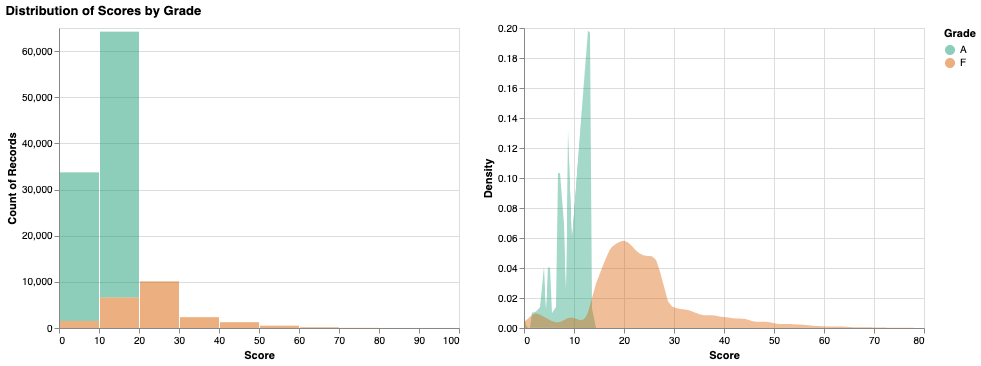

In [66]:
score_hist = (
    alt.Chart(train_df).mark_bar(opacity=0.5).encode(
    alt.X('score', bin=True, scale=alt.Scale(domain=[0, 100]), title='Score'),
    alt.Y('count()'),
    alt.Color('grade', scale=alt.Scale(scheme='dark2'), title='Grade')
))

score_dens_plot = (
    alt.Chart(
    train_df
).transform_density(
    'score',
    groupby=['grade'],
    as_=['score', 'density'],
    extent=[0, 80],
).mark_area(opacity=0.4).encode(
    alt.X('score', title='Score'),
    alt.Y('density:Q', title='Density'),
    alt.Color('grade', scale=alt.Scale(scheme='dark2'), title='Grade')
))

score_dists = (score_hist | score_dens_plot).properties(title='Distribution of Scores by Grade')
# score_dists.save('score_dists.png')
score_dists

**Figure 1.** Histograms and density plots of the distribution of inspection scores across grades. Green represents Grade A restaurants and orange represents Grade F (below Grade A) restaurants.

It seems that Grade F restaurants are associated with higher scores on average, though some Grade F inspections also received low scores (nearly 10,000 are < 20). We can interpret the score as being higher for more severe/critical health violations, but there does not seem to be a standard cut-off for when a restaurant is considered Grade A or not.

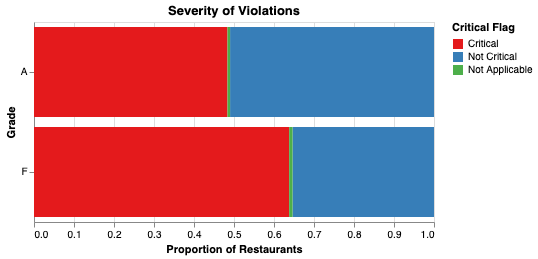

In [46]:
alt.Chart(train_df).mark_bar().encode(
    alt.X('count()', stack='normalize', title='Proportion of Restaurants'),
    alt.Y('grade', title='Grade'),
    alt.Color('critical_flag', scale=alt.Scale(scheme='set1'), title='Critical Flag', sort='-x')
).properties(title='Severity of Violations', height=200)

**Figure 2.** Proportion of restaurants that received critical (red) and non-critical (blue) violations by grade. Violations that are unclassified received a 'Not Applicable' flag (green).

We observe a similar relationship with the assignment of critical flags. Grade F restaurants receive proportionately more critical flags as expected, though almost 50% of Grade A restaurants had critical violations during their inspection! It is not clear what the threshold for a "critical" violation is, thus it will be interesting to see whether our model(s) can identify if the severity of a violation actually matters for grading.

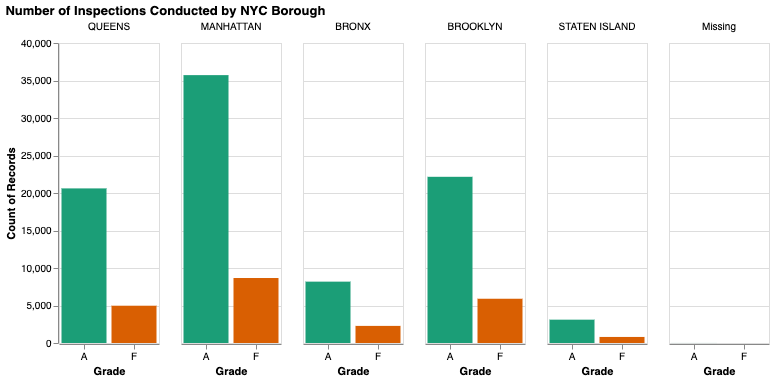

In [47]:
alt.Chart(train_df).mark_bar().encode(
    alt.X('grade', axis=alt.Axis(labelAngle=0), title='Grade'),
    alt.Y('count()'),
    alt.Color('grade', scale=alt.Scale(scheme='dark2'), title='Grade', legend=None),
    alt.Column('boro', title=None, sort=["BRONX", "BROOKLYN", "MANHATTAN", "QUEENS", "STATEN ISLAND", "Missing"])
).properties(height=300, width=100, title='Number of Inspections Conducted by NYC Borough')

**Figure 3.** Number of inspections performed in each NYC borough by grade, where green represents Grade A and orange represents Grade F. The 'Missing' category contains 8 records which are all Grade A.

Each of the NYC boroughs contain mostly Grade A restaurants, thus we should be able to safely eat in any area. We can see that most of the inspections were conducted in Manhattan, which also has the most Grade F restaurants compared to all the other boroughs.

In [85]:
cuisine_count_df = pd.DataFrame(train_df['cuisine_description'].value_counts())
print('Total number of cuisines: ' + str(len(cuisine_count_df)))
cuisine_count_df.loc[cuisine_count_df['cuisine_description'] < 100]

Total number of cuisines: 85


,cuisine_description
Chinese/Cuban,92
Australian,89
Hotdogs/Pretzels,85
Pancakes/Waffles,83
Ethiopian,82
English,71
Moroccan,62
Egyptian,58
Afghan,56
Portuguese,41


In [80]:
top_10_cuisine_df = pd.DataFrame(train_df['cuisine_description'].value_counts()[:10])
top_10_cuisine_df.index.name = 'Cuisine Description'
top_10_cuisine_df.columns = ['Count of Records']
top_10_cuisine_df

,Count of Records
Cuisine Description,
American,25312
Chinese,11476
CafÃ©/Coffee/Tea,5832
Pizza,5049
Italian,4610
"Latin (Cuban, Dominican, Puerto Rican, South & Central American)",4566
Mexican,4275
Japanese,3891
Caribbean,3506


**Table 3.** Number of inspections performed for the top 10 most common cuisine types.

The majority of restaurants in NYC serve American food, followed by Chinese food. The data set also includes food locations that are not necessarily "restaurants" (cafes, bakeries, etc.). Of the 85 unique cuisine descriptions, there are 25 cuisine types that appear less than 100 times in the training set.

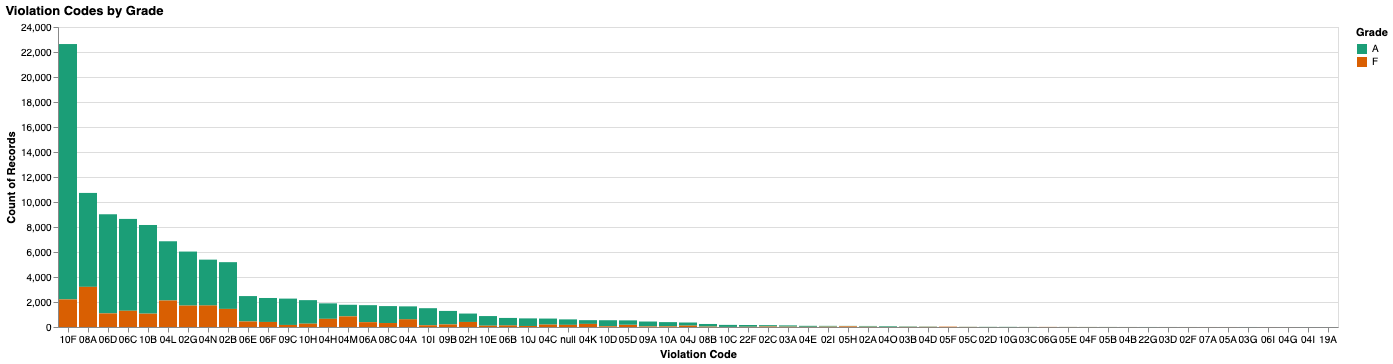

In [89]:
alt.Chart(
    train_df,
).mark_bar().encode(
    alt.X('violation_code', sort='-y', axis=alt.Axis(labelAngle=0), title='Violation Code'),
    alt.Y('count()'),
    alt.Color('grade', scale=alt.Scale(scheme='dark2'), title='Grade')
).properties(
    title='Violation Codes by Grade'
).configure_title(anchor='start')

## Additional Figures

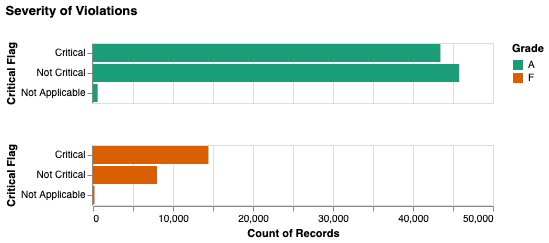

In [44]:
# Original plot of violations by grade, side by side
alt.Chart(train_df).mark_bar().encode(
    alt.X('count()'),
    alt.Y('critical_flag', title='Critical Flag', sort='-x'),
    alt.Color('grade', scale=alt.Scale(scheme='dark2'), title='Grade')
).facet(
    alt.Row('grade', header=alt.Header(labelExpr="''"), title=None),
    columns=1
).properties(title='Severity of Violations')

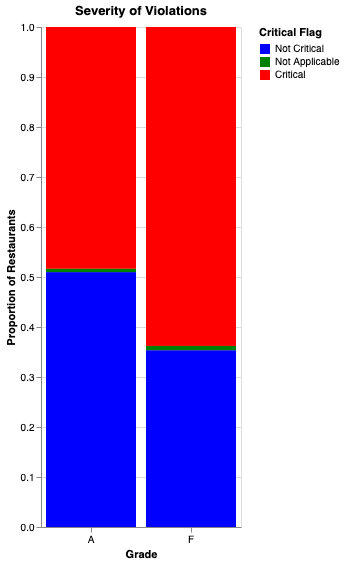

In [64]:
# This is the same plot as Figure 2, but vertical
domain = ['Not Critical', 'Not Applicable', 'Critical']
range_ = ['blue', 'green', 'red']

alt.Chart(train_df).mark_bar().encode(
    alt.X('grade', axis=alt.Axis(labelAngle=0), title='Grade'),
    alt.Y('count()', stack='normalize', title='Proportion of Restaurants'),
    alt.Color('critical_flag', scale=alt.Scale(domain=domain, range=range_), title='Critical Flag', sort='-x')
).properties(title='Severity of Violations', height=500, width=200)

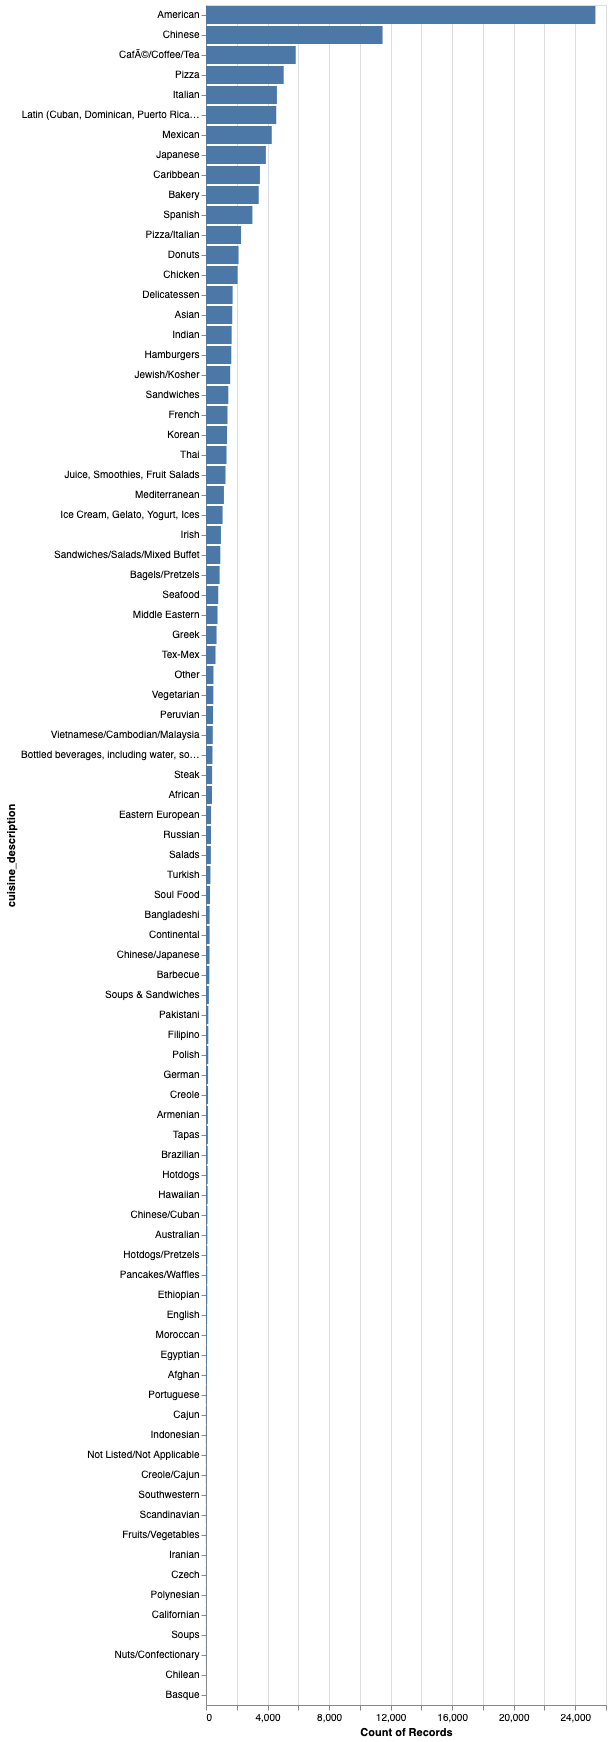

In [49]:
# There are a lot of different cuisines!
alt.Chart(
    train_df,
).mark_bar().encode(
    alt.X('count()'),
    alt.Y('cuisine_description', sort='-x')
)

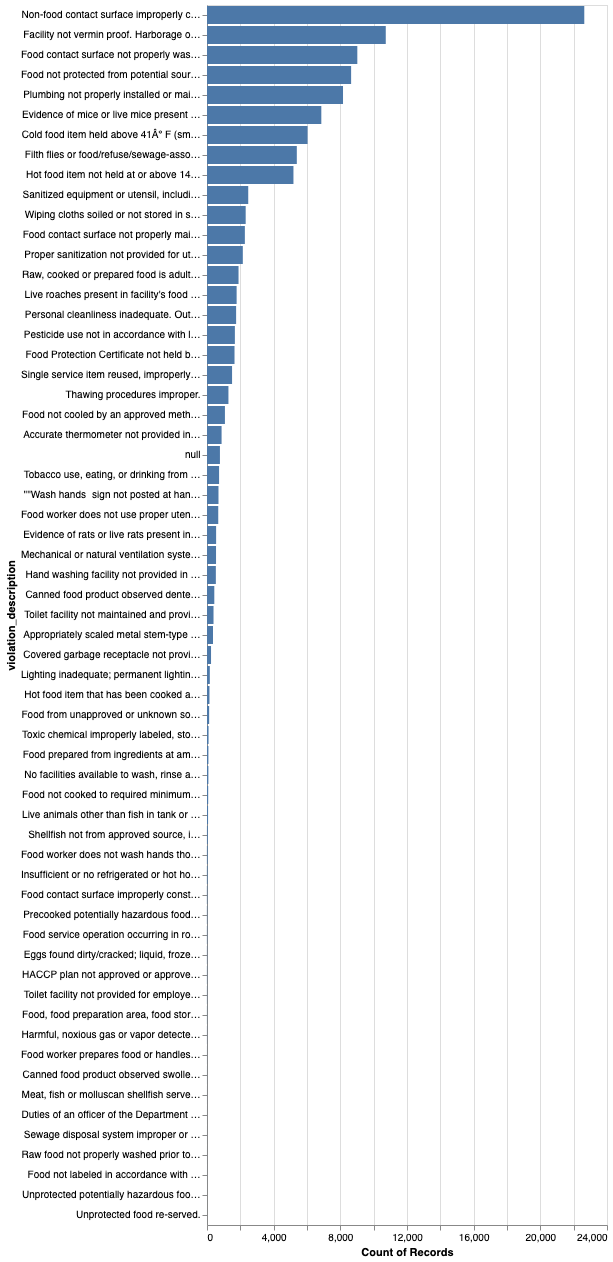

In [54]:
# There are a fixed number of violation descriptions
alt.Chart(
    train_df,
).mark_bar().encode(
    alt.X('count()'),
    alt.Y('violation_description', sort='-x')
)

/Users/lzung/opt/miniconda3/envs/nyc_rest/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


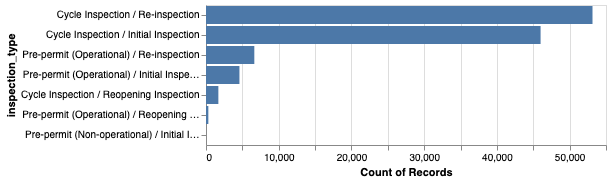

In [63]:
# There are a fixed number of inspection types
alt.Chart(
    train_df,
).mark_bar().encode(
    alt.X('count()'),
    alt.Y('inspection_type', sort='-x')
)

## References

Mock, T (2022). *Tidy Tuesday: A weekly data project aimed at the R ecosystem.* https://github.com/rfordatascience/tidytuesday.

NYC Open Data Portal (2022). *DOHMH New York City Restaurant Inspection Results.* https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j/data